# Segmenting and Clustering Neighborhoods in Toronto

The first step in this lab is to preprocess the data and transform the data into a pandas dataframe. Since Foursquare requires the latitude and longitude data, those values for each postal code will be added. We will only focus on the boroughs with the string 'Toronto' for the remainder of the lab so the resulting dataframe will satisfy this condition. 

The next step is to use Foursquare to find nearby venues at each of the postal codes. Using this data, we can find the most popular types of venues at each postal code and generate a clustering to show the most popular types of venues per area.


***

## Preprocessing Data and Transform Data into Pandas Dataframe

In this section, we will scrape a wikipedia page and transform that data into a pandas dataframe. The site that will be used is https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. 

There are two methods for transferring table data into a dataframe: using web scraping libraries/packages or by using just pandas. We will be doing the web scraping method by using the BeautifulSoup library. During the preprocessing, we will also filter the dataframe so that only boroughs containing the string 'Toronto' will be displayed in the dataframe.

### Imports

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd 

### Obtain HTML Content

In [2]:
website='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
file=urllib.request.urlopen(website);
htmlContent=file.read().decode('utf8')
file.close()

soup=BeautifulSoup(htmlContent,'html.parser')
# print(soup.table.prettify()) //HTML code for the table

### Analyze HTML and Create Dictionary

As you scroll down the HTML code, you reach a 'table' tag. Inside the table tag is where the table resides. Each row is wrapped with a 'tr' tag. Each element in the header section of the table is wrapped with a 'th' tag while every element in the data section of the table is wrapped with a 'td' tag.

The dictionary is initialized by adding the column names as keys and empty lists as values. The dictionary will eventually be transformed into a pandas dataframe.

    Useful link: https://beautiful-soup-4.readthedocs.io/en/latest/

In [3]:
#Returns plain text of element. No trailing spaces
def textValue(tableElement):
    return tableElement.text.rstrip();

In [4]:
tableRows=soup.table.find_all('tr')            # all rows of table with tags
colNames=tableRows[0].find_all('th')           # first row (col names with tags)

dict={}
for col in colNames:                        #set column names
    dict[textValue(col).replace(" ","")]=[] #remove trailing '\n' and delete spaces
dict

{'PostalCode': [], 'Borough': [], 'Neighborhood': []}

### Process Data and Create Dataframe
While adding the data into the dictionary, we need to handle a few conditions. 

    Conditions:
    1. The added tuple must not have a borough that is 'Not Assigned'
    2. Rows with the same postal code must be combined into one row with a concatenated list of neighborhoods
    3. Replace any empty neighborhoods with its corresponding borough name
    
After all the data is added into the dictionary, a dataframe (toronto) is created using the dictionary.

    Useful link: https://datatofish.com/create-pandas-dataframe/

In [5]:
#Dictionary values
columns=list(dict.keys())

postalCodes=dict[columns[0]]
boroughs=dict[columns[1]]
neighborhoods=dict[columns[2]]


for i in range(1,len(tableRows)):
    rowValues=tableRows[i].find_all('td');
    
    #Row values
    postalCode=textValue(rowValues[0]);
    borough=textValue(rowValues[1]);
    neighborhood=textValue(rowValues[2]);
    
    #Condition 1
    if(borough != 'Not assigned'):
        #Condition 2
        if(postalCode in postalCodes):
            index=postalCodes.index(postalCode)
            neighborhoods[index]=neighborhoods[index]+', '+neighborhood
        else:
            for col,val in zip(dict.keys(),rowValues):
                dict[col].append(textValue(val))
#Condition 3
for i in range(0,len(neighborhoods)):
    if(neighborhoods[i]==''):
        neighborhoods[i]=boroughs[i]
        
toronto=pd.DataFrame(dict,columns=dict.keys())
# pd.set_option('display.max_rows', toronto.shape[0]+1)                  #This is used to show all rows 
toronto.head()


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Shape of Dataframe

In [6]:
toronto.shape

(103, 3)

### Longitude and Latitude of Each Postal Code

In this section, we will add latitude and longitude data for each postal code. Because the geographical coordinates were unobtainable using the geocoder package, the data is imported using a CSV file. The CSV file will be read into a new pandas dataframe, coordinates. Finally, we will merge the dataframes, coordinates and toronto, using inner join. 
    
    Inner join means that we only contain rows where the postal codes are equal. If the rows are not equal, they will be omitted.

In [7]:
coordinates=pd.read_csv('Geospatial_Coordinates.csv')
coordinates.rename(columns={'Postal Code':'PostalCode'},inplace=True)
coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
#combine two dataframes using inner join
toronto_data=pd.merge(toronto,coordinates, on='PostalCode',how='inner')
toronto_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Business reply mail Processing Centre,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


### Filter Data by Borough Containing 'Toronto'

In [9]:
toronto_data = toronto_data[toronto_data['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


***
## Retrieve Venues by Postal Code Using Foursquare


### Imports

In [10]:
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import json
import numpy as np
import os
import requests

### Foursquare API Key and Secret

In [11]:
CLIENT_ID = os.environ.get('FOURSQUARE_KEY')
CLIENT_SECRET = os.environ.get('FOURSQUARE_SECRET')
VERSION = '20200101'

### Helper Functions For Getting Venues

In [12]:
# Modified from the New York Lab
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
              'Latitude', 
              'Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
    
    return(nearby_venues)

### Venues by Postal Code

In [13]:
venues = getNearbyVenues(names=toronto_data['PostalCode'],
                         latitudes=toronto_data['Latitude'],
                         longitudes=toronto_data['Longitude']
                        )
venues.head()

,PostalCode,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,M5A,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,M5A,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [14]:
print("unique rows: ",venues['PostalCode'].unique().shape[0])
print("total rows: ",venues.shape[0])

unique rows:  39
total rows:  1596


In [15]:
# print(venues.groupby('PostalCode').count())

***
## Popular Venue Types in Toronto by Postal Code

### One Hot Encoding for Venue Types

In [16]:
# Modified from the New York Lab

# New dataframe with the one hot encodings for venue
toronto_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add postal code column to the one hot dataframe
toronto_onehot['PostalCode'] = venues['PostalCode'] 

# move postal code column (last column) to the first column by changing the order of column name
column_order = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[column_order]

toronto_onehot.head()

,PostalCode,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group By Postal Code 
As you can see above, multiple rows of the dataframe may have the same postal codes. To make each row's postal code unique, we can group by 'PostalCode' and obtain the mean for each attribute. 

In [17]:
toronto_onehot_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_onehot_grouped.head()

,PostalCode,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.25000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.00000
1,M4K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,0.0,...,0.02381,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.02381
2,M4L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.00000
3,M4M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.025,0.0,0.0,0.02500
4,M4N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.00000


### Order Venues by Popularity

In [18]:
# Modified from the New York Lab
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
# Modified from the New York Lab
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postalCode_venues_sorted = pd.DataFrame(columns=columns)
postalCode_venues_sorted['PostalCode'] = toronto_onehot_grouped['PostalCode']

for ind in np.arange(toronto_onehot_grouped.shape[0]):
    postalCode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_onehot_grouped.iloc[ind, :], num_top_venues)

postalCode_venues_sorted.head()
           

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Trail,Neighborhood,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Restaurant,Furniture / Home Store,Yoga Studio,Spa,Indian Restaurant,Pub
2,M4L,Sandwich Place,Park,Fast Food Restaurant,Gym,Steakhouse,Fish & Chips Shop,Intersection,Italian Restaurant,Liquor Store,Brewery
3,M4M,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Neighborhood,Sandwich Place,Cheese Shop,Clothing Store
4,M4N,Park,Swim School,Bus Line,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


***
## K Means Clustering by Postal Code

### Imports

In [20]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

### Clustering Data

In [21]:
# drop postal code (not needed in clustering)
toronto_clustering = toronto_onehot_grouped.drop('PostalCode', axis=1)

### Yellowbrick Elbow Plot to Find K
For clustering, plotting the distortion vs k-value is a good way to find the perfect k-value. The elbow in the graph is the optimum k-value. In this section, we will use the yellowbrick package to help simplify this process. The default distortion metric that is used within this package is sum of squared error. The error is the distance between a point within the cluster to its centroid.

    Useful Link: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

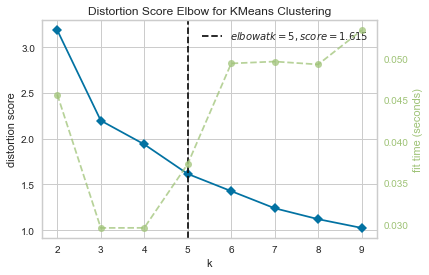

In [22]:
model=KMeans(random_state=0)
visualizer=kelbow_visualizer(model, toronto_clustering, k=(2,10))
visualizer.fit(toronto_clustering)
visualizer.show()

### K-Means Clustering with K=5

In [23]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:39] 

array([1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

***
## Using Folium

### Imports

In [24]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim

### Find Toronto Latitude and Longitude

In [25]:
# find location of Toronto
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
toronto_latitude = location.latitude
toronto_longitude = location.longitude

### Merge Preprocessed Data with Ordered Popularity Venues
Add the generated cluster labels from k-means clustering to the most popular venue dataframe (postalCode_venues_sorted). Join the toronto_data with postalCode_venues_sorted on postal code. 

    'Join' means the two dataframes are concatenated together using all possible pairings. 'On postal code' means that the resulting dataframe must satisfy the condition that the postal codes are equal.

In [26]:
# add clustering labels to the sorted popularity dataframe
postalCode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# join
toronto = toronto_data.join(postalCode_venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Yoga Studio,Cosmetics Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Diner,Sandwich Place,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Cosmetics Shop,Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Café,Japanese Restaurant,Italian Restaurant,Tea Room
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gastropub,Gym,Beer Bar,Creperie,Moroccan Restaurant,Department Store
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Trail,Neighborhood,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


### Plot Clusters on Map

In [28]:
# Modified from the New York Lab

# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto['Latitude'], toronto['Longitude'], toronto['PostalCode'], toronto['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the Clusters
In this section we will look at the postal codes that belong to the same clusters. Each cluster is represented by a color on the map. They are represented by numbers 0-4 in the toronto dataframe.

In [30]:
toronto.loc[toronto['Cluster Labels']==0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307,0,Park,Jewelry Store,Trail,Sushi Restaurant,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
33,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Park,Playground,Trail,Yoga Studio,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


In [31]:
toronto.loc[toronto['Cluster Labels']==1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Yoga Studio,Cosmetics Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Diner,Sandwich Place,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Cosmetics Shop,Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Café,Japanese Restaurant,Italian Restaurant,Tea Room
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gastropub,Gym,Beer Bar,Creperie,Moroccan Restaurant,Department Store
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Trail,Neighborhood,Health Food Store,Pub,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cocktail Bar,Seafood Restaurant,Beer Bar,Bakery,Cheese Shop,Café,Restaurant,Jazz Club,Hotel
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Salad Place,Thai Restaurant,Japanese Restaurant,Ice Cream Shop,Bar,Burger Joint
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,1,Grocery Store,Café,Park,Baby Store,Coffee Shop,Restaurant,Italian Restaurant,Athletics & Sports,Diner,Nightclub
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,Coffee Shop,Café,Restaurant,Gym,Clothing Store,Deli / Bodega,Hotel,Thai Restaurant,Sushi Restaurant,Concert Hall
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,1,Bakery,Pharmacy,Supermarket,Middle Eastern Restaurant,Bank,Bar,Café,Pool,Brazilian Restaurant,Brewery


In [32]:
toronto.loc[toronto['Cluster Labels']==2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M5N,Central Toronto,Roselawn,43.711695,-79.416936,2,Garden,Yoga Studio,Department Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


In [33]:
toronto.loc[toronto['Cluster Labels']==3]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.38316,3,Park,Yoga Studio,Department Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


In [34]:
toronto.loc[toronto['Cluster Labels']==4]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,M4N,Central Toronto,Lawrence Park,43.72802,-79.38879,4,Park,Swim School,Bus Line,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


Observation:

    As you may observe, a large portion of Toronto is made up of places to eat. The postal codes that do not fall into that cluster focuses more on nature, school, education, etc. Those neighborhoods are not common in boroughs with the word 'Toronto'.

<!-- This notebook was created and authored by Teresa Wang -->

This notebook was created and authored by Teresa Wang